In [5]:
import numpy as np
import pandas as pd
import xarray as xr
# from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
# from meteostat import Hourly,Point
from sklearn.metrics import mean_absolute_percentage_error
# from statsmodels.tsa.stattools import adfuller
# from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from utils import *
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

In [7]:
from dataset import Dataset

In [8]:
plot_x_size, plot_y_size = 10,2

In [9]:
uebb = '/Users/ata/Desktop/tüb_dersler/mlses/UEBB_v1.nc'
ds = xr.open_dataset(uebb)
df = ds.to_dataframe()
df = df.reset_index()

In [6]:
high_empty_fields = ['wind_direction_std','air_temperature','relative_humidity', 'UST','UST_flag', 'HS','HS_flag', 'TKE',
                     'LMO','ws_w_corrected']
missing_fields_neighbor = ['wind_speed','wind_direction','wind_speed_std','wind_speed_max','wind_speed_min',
                         'wind_speed_cube','air_pressure','logger_temperature', 'battery_V','ws_u','ws_v','ws_w',
                         'tilt_X','tilt_Y','tilt_X_std','tilt_Y_std','wind_speed_nacelle','wind_speed_nacelle_max',
                         'wind_speed_nacelle_min','rotor_rpm','rotor_rpm_max','rotor_rpm_min','active_power_total',
                         'active_power_total_max','active_power_total_min','act_position','air_density']

max_min_norm = ['sonic_temperature','sonic_wind_speed','sonic_wind_direction',]

In [10]:
dataset = Dataset(df)
dataset.fill_nan(missing_fields_neighbor)
dataset.drop_nan(high_empty_fields)
dataset.sample(200) # converting data to 10minute format

In [27]:
train_x,val_x, test_x, train_y,val_y, test_y =dataset.create_dataset(dataset.get_df()['active_power_total'], 6*24, 1)

# Modelling

In [28]:

train_y = train_y.flatten()
test_y = test_y.flatten()
val_y = val_y.flatten()

In [29]:
params = {'learning_rate': 0.01,
          'objective':'RMSE',
          'use_best_model': True,
          'thread_count':8,
          'iterations': 1000,
        # 'n_estimators':500,
           'max_depth': 10,
           'objective':'RMSE',
          }

model = CatBoostRegressor(**params)

model.fit(train_x, train_y,
          eval_set = [(val_x, val_y)],
          #early_stopping_rounds = 10,
          verbose = 500)

0:	learn: 221.9639954	test: 292.1593237	best: 292.1593237 (0)	total: 122ms	remaining: 2m 2s
500:	learn: 69.8540303	test: 58.6928303	best: 58.6919116 (499)	total: 1m 1s	remaining: 1m 1s
999:	learn: 64.0667721	test: 57.5334592	best: 57.5334592 (999)	total: 1m 58s	remaining: 0us

bestTest = 57.5334592
bestIteration = 999



  Catboost MAE: 53.6738
  Catboost RMSE: 77.0668


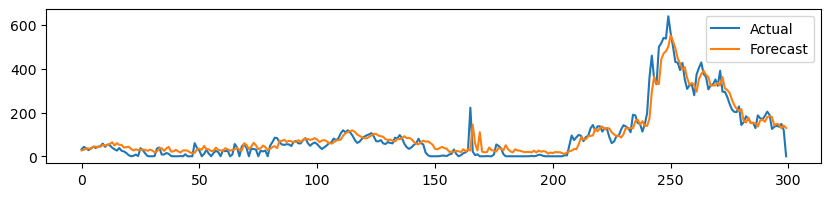

In [31]:
forecast = model.predict(test_x)



print('  Catboost MAE: %.4f' % (np.mean(np.abs(forecast - test_y))))
print('  Catboost RMSE: %.4f' % (np.sqrt(np.mean((forecast - test_y)**2))))

forecast_index = np.arange(len(forecast))
forecast = pd.DataFrame({'forecast': forecast}, index=forecast_index)

plt.rcParams['figure.figsize'] = [plot_x_size, plot_y_size]

plt.plot(test_y[:300], label = 'Actual')
plt.plot(forecast[:300], label = 'Forecast')
plt.legend()
plt.show()

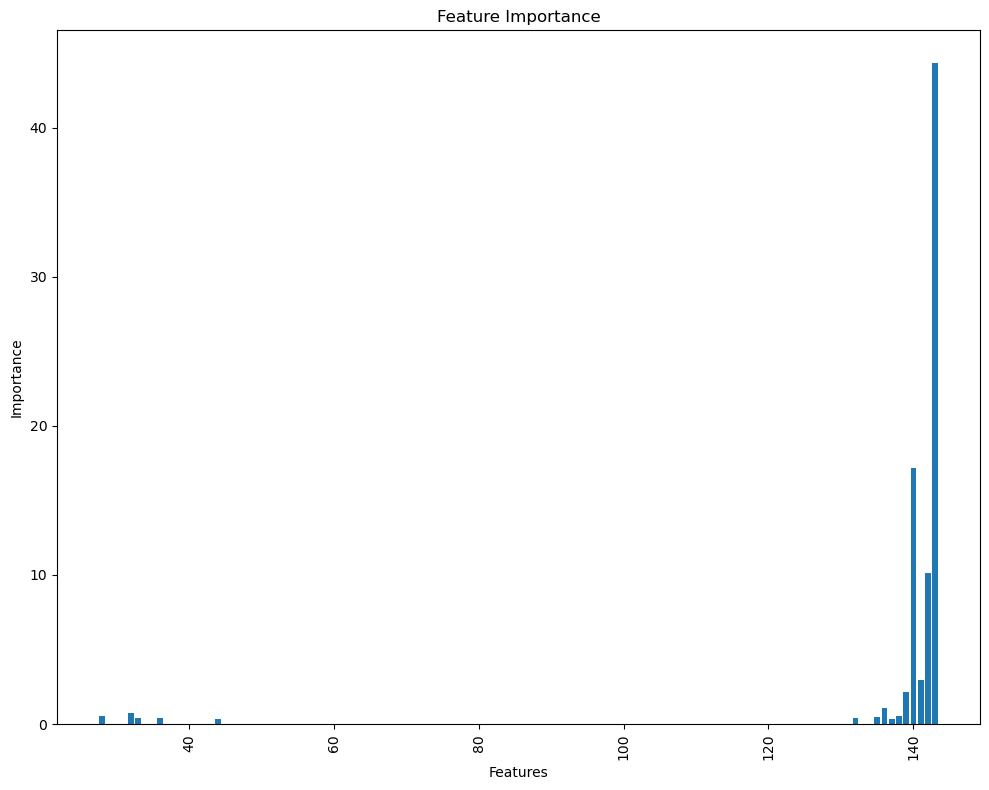

In [21]:
# window_size = 6*24
# feature_name_list = ['lag_' + str(i+1) for i in range(window_size)]
# feature_importance = model.get_feature_importance()
# # sort the feature importance values in descending order
# idx_sorted = np.argsort(feature_importance)[::-1]

# # Create a bar plot of feature importance
# plt.figure(figsize=(10, 8))

# plt.bar(idx_sorted[:15], feature_importance[idx_sorted[:15]])
# plt.xticks(rotation=90)
# plt.xlabel('Features')
# plt.ylabel('Importance')
# plt.title(f'Feature Importance')
# plt.tight_layout()
# plt.show()

## 1 H prediction

In [11]:
window_size = 144
prediction_horizon = 6

train_x,val_x, test_x, train_y,val_y, test_y =dataset.create_dataset(dataset.get_df()['active_power_total'], window_size, prediction_horizon)

In [38]:
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((25081, 144), (25081, 6), (8404, 144), (8404, 6))

In [16]:
from sklearn.multioutput import MultiOutputRegressor

params = {'learning_rate': 0.01,
          'objective':'RMSE',
          'use_best_model': True,
          'thread_count':8,
          'iterations': 1000,
        # 'n_estimators':500,
           'max_depth': 10,
           'objective':'MultiRMSE',
          }

model = MultiOutputRegressor(CatBoostRegressor(), n_jobs = -1)

model.fit(train_x, train_y,)

Learning rate set to 0.06812
Learning rate set to 0.06812
Learning rate set to 0.06812
Learning rate set to 0.06812
Learning rate set to 0.06812
0:	learn: 214.6833596	total: 130ms	remaining: 2m 9s
0:	learn: 212.5890508	total: 190ms	remaining: 3m 10s
1:	learn: 206.3884997	total: 248ms	remaining: 2m 3s
0:	learn: 213.1437723	total: 221ms	remaining: 3m 41s
0:	learn: 212.0109121	total: 229ms	remaining: 3m 48s
0:	learn: 214.0739042	total: 257ms	remaining: 4m 16s
1:	learn: 202.2420844	total: 358ms	remaining: 2m 58s
2:	learn: 198.9120289	total: 420ms	remaining: 2m 19s
1:	learn: 201.0843049	total: 369ms	remaining: 3m 3s
1:	learn: 203.2733910	total: 356ms	remaining: 2m 57s
1:	learn: 205.5368384	total: 419ms	remaining: 3m 29s
2:	learn: 192.5959226	total: 486ms	remaining: 2m 41s
2:	learn: 193.8902603	total: 474ms	remaining: 2m 37s
3:	learn: 192.0776148	total: 579ms	remaining: 2m 24s
2:	learn: 190.6372160	total: 513ms	remaining: 2m 50s
2:	learn: 197.4213348	total: 535ms	remaining: 2m 57s
3:	learn: 

MultiOutputRegressor(estimator=<catboost.core.CatBoostRegressor object at 0x7f8966da7ca0>,
                     n_jobs=-1)

Multi-Step MAE: 99.6284


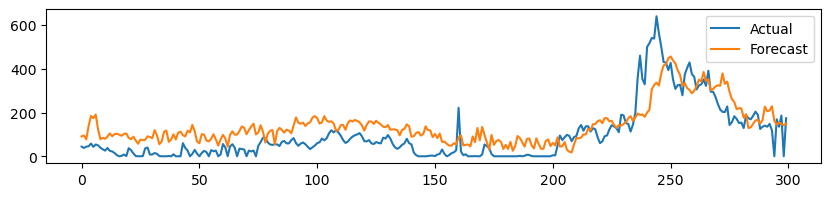

In [17]:
forecast_ms_dir= model.predict(test_x)
forecast =forecast_ms_dir[:,-1]
test_hat = test_y[:,-1]


# print('  One-Step MAE: %.4f' % (np.mean(np.abs(forecast_os - test_y))))
print('Multi-Step MAE: %.4f' % (np.mean(np.abs(forecast- test_hat))))

forecast_index = np.arange(len(forecast))
forecast = pd.DataFrame({'forecast': forecast}, index=forecast_index)
# # forecast_os = pd.DataFrame({'forecast': forecast_os}, index=forecast_index)

plt.rcParams['figure.figsize'] = [plot_x_size, plot_y_size]


plt.plot(test_hat[:300], label = 'Actual')
plt.plot(forecast[:300], label = 'Forecast')

plt.legend()
plt.show()